#**Referensi**

**train model**

https://www.tensorflow.org/lite/guide/model_maker
https://www.tensorflow.org/lite/tutorials/model_maker_object_detection
https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android

**deploy to android**

https://developers.google.com/codelabs/tflite-object-detection-android#0

Tutorial Youtube

https://www.youtube.com/watch?v=5oBH_eLFXrM&t=552s
File Template Android studio untuk deploy tflite ke android

https://github.com/tensorflow/examples

# Install libraries and packages


### Install packages


In [5]:
!pip install -q tflite-model-maker
!pip install -q pycocotools
!pip install -q tflite-support

     |████████████████████████████████| 616 kB 27.9 MB/s 
     |████████████████████████████████| 6.4 MB 51.0 MB/s 
     |████████████████████████████████| 213 kB 62.8 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 1.2 MB 64.4 MB/s 
     |████████████████████████████████| 120 kB 63.6 MB/s 
     |████████████████████████████████| 1.1 MB 52.5 MB/s 
     |████████████████████████████████| 87 kB 8.0 MB/s 
     |████████████████████████████████| 1.1 MB 47.2 MB/s 
     |████████████████████████████████| 3.4 MB 42.2 MB/s 
     |████████████████████████████████| 840 kB 70.8 MB/s 
     |████████████████████████████████| 596 kB 43.2 MB/s 
     |████████████████████████████████| 25.3 MB 62.9 MB/s 
     |████████████████████████████████| 99 kB 10.3 MB/s 
     |████████████████████████████████| 47.7 MB 88 kB/s 
     |████████████████████████████████| 352 kB 35.1 MB/s 
     |████████████████████████████████| 210 kB 51.0 MB/s 


### Impor Libraries

In [6]:
import numpy as np
import pandas
import random
import csv
import cv2

import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

# Prepare the dataset

<br/>

Format File CSV:
```
TRAINING,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Salad,0.0,0.0954,,,0.977,0.957,,
VALIDATION,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Seafood,0.0154,0.1538,,,1.0,0.802,,
TEST,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Tomato,0.0,0.655,,,0.231,0.839,,
```

### Convert File CSV dari Roboflow ke format CSV yg di butuhkan

Roboflow:

Export Dataset ke Tensorflow Object Detection untuk mendapatkan file csv dari dataset yang telah di beri label


In [ ]:
# Membuat Folder baru di colab dengan nama dataset
!mkdir dataset

Bagi dataset ke 100% training di roboflow, lalu export --> show download code

In [ ]:
# Mengimpor Dataset dari Roboflow langsung ke colab
# ganti kode di bawah dengan download code yang di berikan oleh Roboflow saat Export dataset

"""
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="aS7O9I9sNyxf3Nq3rQRD")
project = rf.workspace().project("apples-decay")
dataset = project.version(7).download("tensorflow") 
"""

In [ ]:
dataset_dir = 'dataset2/train'

# masukkan nama file csv dari roboflow
original_csv_name = 'labels.csv'

original_csv_path = os.path.join(dataset_dir, original_csv_name)

In [ ]:
dataset = pd.read_csv(original_csv_path)
dataset.head()

In [ ]:
dataset = dataset.drop(['width', 'height'], axis=1)
dataset = dataset.rename(columns={"filename": "image", "class": "label"})
dataset.head()

In [ ]:
# Menghitung jumlah data
image_list = sorted(dataset["image"].unique())
dataset_num = len(dataset["image"].unique())
print('Number of dataset: ' + str(dataset_num))

# Membagi data --> Training data:60%, validation data:20%, Test data:20%)
train_num = int(0.6 * dataset_num)
validation_num = int(0.2 * dataset_num)
test_num = int(0.2 * dataset_num)
print('Number of Train dataset: ' + str(train_num))
print('Number of Validation dataset: ' + str(validation_num))
print('Number of Test dataset: ' + str(test_num))

Number of dataset: 276
Number of Train dataset: 165
Number of Validation dataset: 55
Number of Test dataset: 55


In [ ]:
# Split Training data/validation data/Test data)

use_shuffle = False

if use_shuffle is False:
    train_list = image_list[:train_num]
    validation_list = image_list[train_num:train_num + validation_num]
    test_list = image_list[train_num + validation_num:]
else:
    image_shuffle_list = random.sample(image_list, len(image_list))
    train_list = image_shuffle_list[:train_num]
    validation_list = image_shuffle_list[train_num:train_num + validation_num]
    test_list = image_shuffle_list[train_num + validation_num:]

In [ ]:
dataset_list = []

def convert_csv_format(tag, dataset_list, file_list, dataset_dir):
    result_list = []

    for target_file in file_list:
        for index, row in (dataset_list[dataset_list['image'] == target_file]).iterrows():
            file_path = os.path.join(dataset_dir, row.image)
            temp_image = cv2.imread(file_path)

            image_width, image_height = temp_image.shape[1], temp_image.shape[0]
            xmin = row.xmin / image_width
            ymin = row.ymin / image_height
            xmax = row.xmax / image_width
            ymax = row.ymax / image_height

            result_list.append([tag, file_path, row.label, xmin, ymin, '', '', xmax, ymax, '', ''])

    return result_list

result_list = convert_csv_format('TRAIN', dataset, train_list, dataset_dir)
dataset_list.extend(result_list)

result_list = convert_csv_format('VALIDATE', dataset, validation_list, dataset_dir)
dataset_list.extend(result_list)

result_list = convert_csv_format('TEST', dataset, test_list, dataset_dir)
dataset_list.extend(result_list)

In [ ]:
# Simpan CSV
dataset_csv_file = 'dataset.csv'

with open(dataset_csv_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerows(dataset_list)

#Train Object Detection Model

There are six steps to training an object detection model:

**Step 1. Choose an object detection model archiecture.**

This tutorial uses the EfficientDet-Lite2 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture. 

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>


In [ ]:
# Pilih model
spec = model_spec.get('efficientdet_lite2')

**Step 2. Load the dataset.**

In [ ]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv(dataset_csv_file)

**Step 3. Train the TensorFlow model with the training data.**

* The EfficientDet-Lite0 model uses `epochs = 50` by default, which means it will go through the training dataset 50 times. You can look at the validation accuracy during training and stop early to avoid overfitting.
* Set `batch_size = 8`
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [ ]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, epochs=100, train_whole_model=True, validation_data=validation_data)

**Step 4. Evaluate the model with the test data.**


In [ ]:
model.evaluate(test_data)

1/1 [==============================] - 18s 18s/step



{'AP': 0.6391744,
 'AP50': 0.78838223,
 'AP75': 0.7624736,
 'AP_/Fresh Apple': 0.6391744,
 'AP_/Rotten Apple': -1.0,
 'APl': 0.6423202,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.73571426,
 'ARm': -1.0,
 'ARmax1': 0.6785714,
 'ARmax10': 0.73392856,
 'ARmax100': 0.73571426,
 'ARs': -1.0}

**Step 5.  Export as a TensorFlow Lite model.**

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is full integer quantization.

In [ ]:
model.export(export_dir='.')

In [ ]:
#model.export(export_dir='/content/drive/MyDrive/Colab Notebooks')

**Step 6.  Evaluate the TensorFlow Lite model.**

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop. 
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [ ]:
model.evaluate_tflite('model.tflite', test_data)

56/56 [==============================] - 527s 9s/step



{'AP': 0.4513519,
 'AP50': 0.56227845,
 'AP75': 0.52730757,
 'AP_/Fresh Apple': 0.4513519,
 'AP_/Rotten Apple': -1.0,
 'APl': 0.4514259,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.46964285,
 'ARm': -1.0,
 'ARmax1': 0.46785715,
 'ARmax10': 0.46964285,
 'ARmax100': 0.46964285,
 'ARs': -1.0}

You can download the TensorFlow Lite model file using the left sidebar of Colab. Right-click the `model.tflite` file and choose `Download` to download it to your local computer.

In the next step of the codelab, you'll use the [ObjectDetector API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview) to integrate the model into the Android app.

#Test the TFLite model on your image

You can test the trained TFLite model using images from the internet. 
* Replace the `INPUT_IMAGE_URL` below with your desired input image. 
* Adjust the `DETECTION_THRESHOLD` to change the sensitivity of the model. A lower threshold means the model will pickup more objects but there will also be more false detection. Meanwhile, a higher threshold means the model will only pickup objects that it has confidently detected.

Although it requires some of boilerplate code to run the model in Python at this moment, integrating the model into a mobile app only requires a few lines of code.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#@title Load the trained TFLite model and define some visualization functions

#@markdown This code comes from the TFLite Object Detection [Raspberry Pi sample](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

import platform
import json
import cv2

from typing import List, NamedTuple
from tflite_support import metadata

model_path = '/content/drive/MyDrive/Colab Notebooks/TFLite Model Maker/model.tflite'
Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 2
_TEXT_COLOR = (170, 20, 240) 


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

In [8]:
from PIL import Image

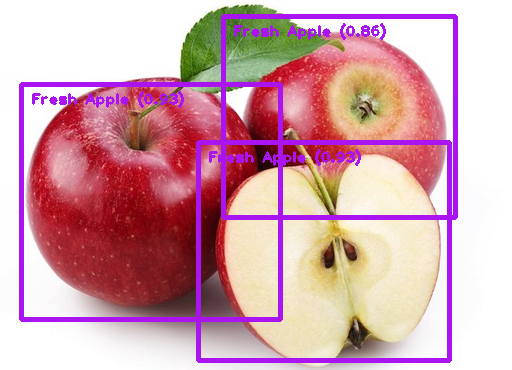

In [11]:
#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "https://faktualnews-prod.s3.ap-southeast-1.amazonaws.com/images/2019/02/apel-1.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

TEMP_FILE = '/content/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(im)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=model_path, options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)